# Camera Pose Estimation

This notebook contains more detailed information on how to use the 7-scenes data set and apply the regression forest with consecutive RANSAC optimization. For detailed information regarding the implementation read our documentation in the **readme.md** file or inspect the comments in the code. For the mathematical background as well as architectural decisions please refer to the corresponding report in the **./report** directory.

At first, we show how to download and clean the data set for a certain scene. Then, the use of the Regresion Forest and RANSAC algorithm is shown and obtained results are subsequently analyzed.

In [1]:
# We do not provide a full package yet and load our python files manually
import sys
sys.path.append('./source/')

***
## 1. Data Loading
In order to get started we first need to download data from the [**7-scenes dataset**](https://www.microsoft.com/en-us/research/project/rgb-d-dataset-7-scenes/). Therefore, just hop into the **/data** folder where you will find a notebook called **load_and_clean_7_scenes_dataset.ipynb**. Just pick a scene of your choice and execute the corresponding cell. 

To get an intuition for the data, we plot a number of `SAMPLES` of random images and corresponding depth maps from the data set `SCENE`. Additionally, the full volumetric image of the scene is displayed. 

Feel free to play around with different scenes in this notebook assuming the corresponding data set has been downloaded.

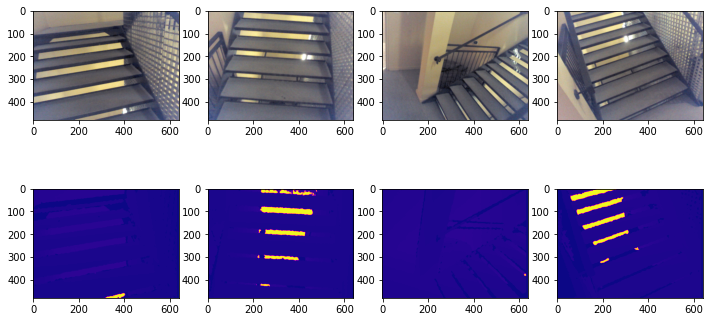

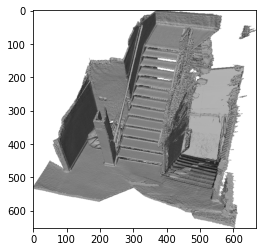

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from source.data_loader import DataLoader 

SCENE = "stairs"         # one of the scenes (name of folder in /data)
DATA_PATH = "./data"    # directory where image data is stored
SAMPLES = 4             # images to display 

# load the data set
loader = DataLoader(DATA_PATH)
indices = np.random.choice(loader.get_dataset_length(SCENE), SAMPLES, replace = False)
images, depths, poses = loader.load_dataset(SCENE, indices)

# plot random images 
_, axes = plt.subplots(2, SAMPLES, figsize=(12,6))
for i in range(SAMPLES):
    axes[0,i].imshow(np.swapaxes(images[i], 1, 0))
    axes[1,i].imshow(depths[i].T, cmap=plt.get_cmap("plasma"))
plt.show()

# plot volume
full_scene = np.array(Image.open(f"./data/{SCENE}/{SCENE}.png"))
plt.imshow(full_scene)

***
## 2. Regression Forest
In this section we provide an approach on how to use our implementation of the Regression Forest. Therefore, we show any hyperparameters used for training and show the results of a trained forest. Look into the **/output** directory to get an overview of pre-trained forests.

### 2.1 Training
To train a forest for a certain scene we provide the script **/source/train_forest.py**. Initially, all hyperparameters must be set and are displayed in the following table:

| Hyperparameter | Default        | 
| ------------- |:-------------:| 
|TEST_SIZE | *0.5* |
|NUM_TREES | 5 |
|TREE_MAX_DEPTH | 16 |
|NUM_TRAIN_IMAGES_PER_TREE | 500 |
|NUM_SAMPLES_PER_IMAGE | 5000   |
|NUM_PARAMETER_SAMPLES | 1024 |
|FEATURE_TYPE | *DA_RGB / DEPTH* |

Make sure to  adjust the test size for each dataset since the values vary among different scenes. Subsequently, the dataset is loaded and split into training and test data. The forest is initialized and the training process started. When the training is finished, the forest object and corresponding parameters are saved in the **/output** folder.

Here, we load a trained forest and display the hypperparameters that have been used.

In [3]:
import os
from source.utils import load_object, millis

OUTPUT = "./output"
PREFIX = "26-03-2022_10-37_stairs"    # folder which contains trained forest and parameters file

params = load_object(os.path.join(OUTPUT, PREFIX, f"params_{SCENE}.pkl"))
print(f'Loading forest trained on "{SCENE}"')

[print(f'\t{key}: {params[key]}') for key in [
    'TIMESTAMP',
    'TREE_MAX_DEPTH',
    'NUM_TREES',
    'NUM_TRAIN_IMAGES_PER_TREE',
    'NUM_SAMPLES_PER_IMAGE',
    'NUM_PARAMETER_SAMPLES',
    'FEATURE_TYPE']]
    
forest = load_object(os.path.join(OUTPUT, PREFIX, f"trained_forest_{SCENE}.pkl"))

Loading forest trained on "stairs"
	TIMESTAMP: 26-03-2022_10-37
	TREE_MAX_DEPTH: 16
	NUM_TREES: 5
	NUM_TRAIN_IMAGES_PER_TREE: 500
	NUM_SAMPLES_PER_IMAGE: 5000
	NUM_PARAMETER_SAMPLES: 1024
	FEATURE_TYPE: FeatureType.DA_RGB


### 2.2 Testing
Now, we can use the trained forest and see how it performs on unseen data. Therefore, the forest is evaluated with randomly sampled test images. The number of test images is specified as `NUM_TEST_IMAGES` and the number of sampled pixels per image is defined as `NUM_SAMPLES_PER_IMAGE`. The resulting array contains the valid predictions of every tree in the forest. 

In [9]:
NUM_TEST_IMAGES = 500
NUM_SAMPLES_PER_IMAGE = 5000

# Sample images from test data set
test_set_indices = params['TEST_INDICES']
test_indices = np.random.choice(test_set_indices, NUM_TEST_IMAGES, replace = False)
images_data = loader.load_dataset(SCENE, test_indices)

# Obtain pixel and world coordinates from sample points
p_s, w_s = loader.sample_from_data_set(
    images_data = images_data,
    num_samples = NUM_SAMPLES_PER_IMAGE)

# Evalulate forest
print(f'Evaluating Forest with {NUM_TEST_IMAGES * NUM_SAMPLES_PER_IMAGE} samples per tree...')

start = millis()
forest_predictions = forest.evaluate(p_s, images_data)
print(f'Finished after {(millis() - start):5.1F}ms')

images_data = None # free memory

Evaluating Forest with 2500000 samples per tree...
Finished after 55424.0ms


### 2.3 Evaluation
Next up, we'll show the results of our training process for the different scenes and evaluate them.

In [10]:
from source.evaluator import SceneCoordinateEvaluator
from source.visualization import draw_pointcloud

Due to the fact, that the feature generation process may lead to invalid features, we have a look at how many of the sampled point from the test data return a valid result. A feature is considered invalid if the shift during feature generation leads to indices that lay outside the image boundary or have an invalid depth value.

In [11]:
eval = SceneCoordinateEvaluator()
valid_predictions = eval.get_valid_predictions(forest_predictions)

total_num_predictions = (NUM_TEST_IMAGES * NUM_SAMPLES_PER_IMAGE * params["NUM_TREES"])
valid_num_predictions = valid_predictions.shape[0]

print(f'The forest exhibits {(valid_num_predictions / total_num_predictions):.2%} valid predictions')

The forest exhibits 90.89% valid predictions


Next up, we calculate the average deviation of the predicted 3D cooordinate with respect to the ground truth. This is calculated for each tree in the forest and as total deviation using the L2-norm.

Tree 1: average deviation = [1.426E+00 +/- 6.239E-01] m
Tree 2: average deviation = [1.356E+00 +/- 5.982E-01] m
Tree 3: average deviation = [1.436E+00 +/- 7.950E-01] m
Tree 4: average deviation = [1.703E+00 +/- 1.040E+00] m
Tree 5: average deviation = [1.453E+00 +/- 6.102E-01] m

Total average deviation = [1.475E+00 +/- 7.334E-01] m


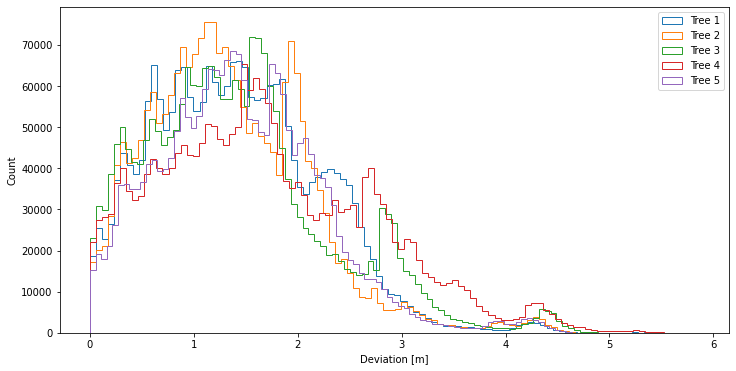

In [12]:
# calculate L2-norm error between predicted and ground truth world coordinates
errors = eval.get_prediction_error(forest_predictions, w_s)

# plot mean error and variance per tree
plt.figure(figsize=(12,6))
for i, err in enumerate(errors):
    plt.hist(err, bins=100, fill=False, histtype='step', label=f'Tree {i+1}')
    print(f'Tree {i+1}: average deviation = [{np.mean(err):1.3E} +/- {np.var(err):1.3E}] m')
    
plt.xlabel('Deviation [m]')
plt.ylabel('Count')
plt.legend()

# plot total error for forest
avg_deviation = np.mean([np.mean(err) for err in errors])
var_deviation = np.mean([np.var(err) for err in errors])

print(f"\nTotal average deviation = [{avg_deviation:1.3E} +/- {var_deviation:1.3E}] m")

For all forests the majority of deviations is between 0 and 2 meters. This may look fairly bad, considering that the RANSAC samples random coordinates from the trees. But, due to the greedy optimization approach, the camera pose optimization still produces adequate results as shown in the sections below. However, there is still potential to optimize our Regression Forest.

Next up it is also interseting to look at the average result of all trees in a forest. 

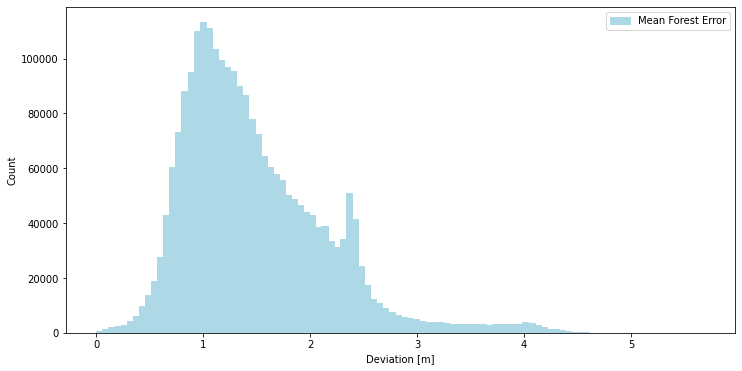

In [13]:
mean_forest_error = eval.get_mean_forest_error(forest_predictions, w_s)
np.save(f"forest_err_{SCENE}.npy", np.array(mean_forest_error))

plt.figure(figsize=(12,6))
plt.hist(mean_forest_error, bins=100, fill=True, histtype='step', color="lightblue", label=f'Mean Forest Error')    
plt.xlabel('Deviation [m]')
plt.ylabel('Count')
plt.legend()



Finally, we plot a pointcloud to show some fancy graphical results.

In [15]:
draw_pointcloud(valid_predictions) # opens an external window

## 3. Predicting Camera Poses
Let's have a look at the predicted camera poses of the RANSAC optimization. We use a trained forest that has been loadded in the previous cells and pass it to the RANSAC optimizer. For validation purposes we are using a number `NUM_TEST_IMAGES` of unseen test images. The camera poses are then predicted for each test image and compared to the corresponding ground truths.

Per Image ~

In [38]:
from source.ransac import Ransac, parallel
from source.evaluator import PoseEvaluator
import multiprocessing

NUM_TEST_IMAGES = 500

# sample images from test data set
test_indices = np.random.choice(params['TEST_INDICES'], NUM_TEST_IMAGES, replace = False)
images_data = DataLoader(DATA_PATH).load_dataset(SCENE, test_indices)

# get ground truth camera poses from image data
ground_truth_poses = images_data[2]

print(f"Predicting poses of scene {SCENE} with {NUM_TEST_IMAGES} test images...")
start = millis()

# start parallel execution of ransac
rans = []
for i in range(NUM_TEST_IMAGES):
    rans.append(Ransac((images_data[0][i][np.newaxis, : ,:], images_data[1][i][np.newaxis, : ,:], images_data[2][i][np.newaxis, : ,:]), forest, np.array([i])))

# obtain predicted poses from multiprocessing worker
with  multiprocessing.Pool(processes= multiprocessing.cpu_count()) as pool:
   poses = pool.map(parallel, rans)

# map poses from workers
predicted_poses = np.zeros((NUM_TEST_IMAGES, 4, 4))
for entry in poses:
    pose = entry[0]
    index = entry[1]
    predicted_poses[index,:,:] = pose

print(f'Finished after {(millis() - start):5.1F}ms')

images_data = None # free memory

Predicting poses of scene fire with 10 test images...


Finished after 104924.0ms


### 3.1 Evaluation
For each pose the translational and angular error is measured in order to evaluate the predicted camera poses. If both are below some threshold `THRESHOLD_TRANSLATIONAL` and `THRESHOLD_ANGULAR`, the pose is considered to be correct. Initially, we use error thresholds of 5cm and 5° as in the corresponding paper. 

In the following, the histograms for translational and angular errors are plotted and evaluated. Then the total amount of correctly classified poses is shown.

In [40]:
from source.evaluator import PoseEvaluator

THRESHOLD_TRANSLATIONAL = 5.  # cm
THRESHOLD_ANGULAR = 5.        # degree

evaluator = PoseEvaluator(THRESHOLD_TRANSLATIONAL, THRESHOLD_ANGULAR)

Average Translational Error = [1.813E+00 +/- 1.704E-01] m


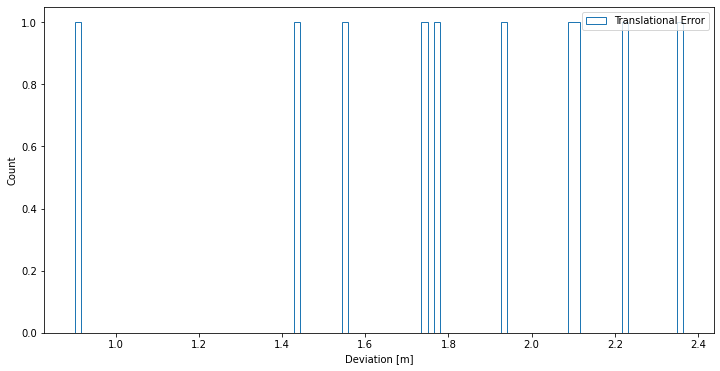

In [41]:
# calculate translational error
error_translation = evaluator.get_translational_error(predicted_poses, ground_truth_poses)

print(f'Average Translational Error = [{np.mean(error_translation):1.3E} +/- {np.var(error_translation):1.3E}] m')

plt.figure(figsize=(12,6))
plt.hist(error_translation, bins=100, fill=False, histtype='step', label=f'Translational Error')    
plt.xlabel('Deviation [m]')
plt.ylabel('Count')
plt.legend()

Average Angular Error = [9.529E+01 +/- 1.587E+03]°


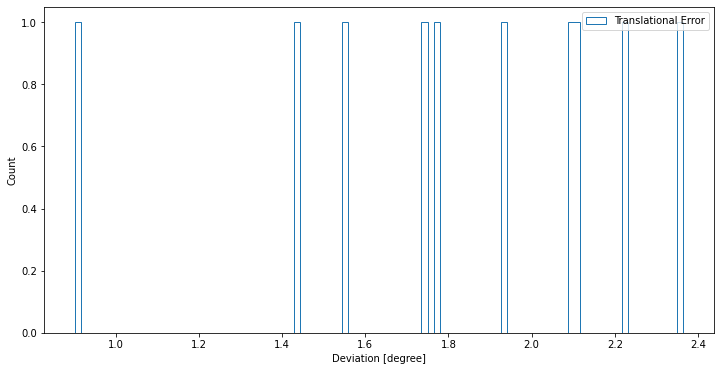

In [42]:
# calculate the angular error
error_angular = evaluator.get_angular_error(predicted_poses, ground_truth_poses)

print(f'Average Angular Error = [{np.mean(error_angular):1.3E} +/- {np.var(error_angular):1.3E}]°')

plt.figure(figsize=(12,6))
plt.hist(error_translation, bins=100, fill=False, histtype='step', label=f'Translational Error')    
plt.xlabel('Deviation [degree]')
plt.ylabel('Count')
plt.legend()

In [44]:
error = evaluator.evaluate(predicted_poses, ground_truth_poses)

print(f'The amount of correctly classified poses with \
translational threshold = {THRESHOLD_TRANSLATIONAL} cm and \
angular threshold = {THRESHOLD_ANGULAR}° \n \
is {error:.2%}')

The amount of correctly classified poses with translational threshold = 5.0 cm and angular threshold = 5.0° 
 is 0.00%
